# DATA SCIENCE 4440 Final Project
#### Eddy Mina 

The proposed idea for this project is inspired by the Apple Watch Series 4 and modern-day ECG machines. ECG’s or electrocardiograms are heart monitoring devices that measure the hearts’ normal sinus rhythm. Biologically speaking, cardiac muscles generate a wave pattern through depolarization and repolarization of each beat. ECG measurements are recorded by the placement of up to 12 electrodes on the body that can measure the overall magnitude of the hearts electric potential. A single heart beat voltage signal can be examined with a P wave which represents the depolarization of the atria; the QRS complex which illustrates ventricle depolarization of the atria, and finally the T wave, which indicates ventricle repolarization. The image below shows a common signal repeat unit of this waveform. 

<img src="heartbeat.png">
 
The primary objective of this project is to use a 1D Convolutional Network paired with a Multilayer perceptron that finds unhealthy signal in a continous heart beat. All code is public and can be manipulated for use. 


The data used will be from the MIT-BIH Arrhythmia Database. The following database, collecting data from as far as 1975 has 48 instances of 30 minute (360 samples/sec) ECG records from 47 patients at Beth-Israel Hospital. “Twenty-three recordings were chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%). The remaining 25 recordings were selected from the same set to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample.” All data exists per patients in the form of csv files and instances of annotated by associate txt files.

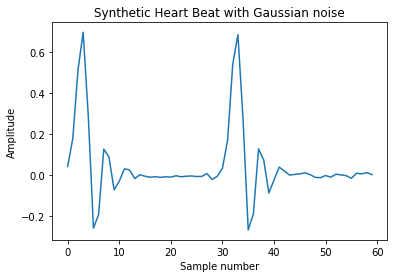

In [0]:
import numpy as np
import matplotlib.pyplot as plt 
bpm = 60
bps = bpm / 60
capture_length = 2
# plt.xlim(0,10)
num_heart_beats = int(capture_length * bps)
ecg_template = np.tile(pqrst_full , num_heart_beats) 
noise = np.random.normal(0, 0.01, len(ecg_template))
ecg_template_noisy = noise + ecg_template

# Plot the noisy heart ECG template
plt.plot(ecg_template_noisy)
plt.xlabel('Sample number')
plt.ylabel('Amplitude')
plt.title('Synthetic Heart Beat with Gaussian noise')
plt.show()

---
# Signal Processing 
#### 1. Getting MIT Data Base  https://physionet.org/physiobank/database/html/mitdbdir/intro.htm
#### 2. Selecting Relevant Classes 
#### 3. HB Isolation Algorithm
#### 4. Filter and Resample 
#### 5. Push to Google COLAB GPU
---


### Import Relevant Packages 
#### Make sure heartbeat.py and normalizer.py are in the same directory
#### There also must be a folder called mit_data (attached in zip file) where all data is stored

###### `heartbeat.py`  is a small written signal processing library and `normalizer.py` has several other util functions

In [0]:
import warnings
#warnings.simplefilter(action='ignore', category=FutureWarning) #turn off irrelevant scipy future warning 
import heartbeat as hb
import normalizer
import importlib
import random 
import time 
import pandas as pd 
import numpy as np
from collections import Counter
from scipy import signal
from scipy.signal import find_peaks, resample
import matplotlib.pyplot as plt 
import seaborn as sns
import os 
from os import listdir
from os.path import isfile, join
import sys
import warnings 
importlib.reload(hb)
importlib.reload(normalizer)

print('Packages Loaded')

Packages Loaded


### Data is in the directory in a folder call mit_data with csv and txt files 

In [0]:
print('Files in Directory {}:\n'.format(os.getcwd()+'/mit_data'))
print('-------------------------------\n')
onlyfiles = [f for f in listdir(os.getcwd()+'/mit_data') if isfile(join(os.getcwd()+'/mit_data', f))]
print(sorted(onlyfiles)[1:],'\n\n***',len(onlyfiles)-1,'data files ***')   

print('\nAll patients:\n',hb.all_patients())

Files in Directory /Users/eddymina/Code/Python/Notebooks/DS4440/DS_Final/mit_data:

-------------------------------

['100.csv', '100annotations.txt', '101.csv', '101annotations.txt', '102.csv', '102annotations.txt', '103.csv', '103annotations.txt', '104.csv', '104annotations.txt', '105.csv', '105annotations.txt', '106.csv', '106annotations.txt', '107.csv', '107annotations.txt', '108.csv', '108annotations.txt', '109.csv', '109annotations.txt', '111.csv', '111annotations.txt', '112.csv', '112annotations.txt', '113.csv', '113annotations.txt', '114.csv', '114annotations.txt', '115.csv', '115annotations.txt', '116.csv', '116annotations.txt', '117.csv', '117annotations.txt', '118.csv', '118annotations.txt', '119.csv', '119annotations.txt', '121.csv', '121annotations.txt', '122.csv', '122annotations.txt', '123.csv', '123annotations.txt', '124.csv', '124annotations.txt', '200.csv', '200annotations.txt', '201.csv', '201annotations.txt', '202.csv', '202annotations.txt', '203.csv', '203annotatio

### All Types of Heat Beat Conditions from the Data Base
https://physionet.org/physiobank/annotations.shtml

In [0]:
print("MIT DATABASES CONDITIONS:\n")
hb.classes_further

MIT DATABASES CONDITIONS:



{'N': 'Normal beat',
 'L': 'Left bundle branch block beat',
 'R': 'Right bundle branch block beat',
 'A': 'Atrial premature beat',
 'a': 'Aberrated atrial premature beat',
 'J': 'Nodal (junctional) premature beat',
 'S': 'Supraventricular premature beat',
 'V': 'Premature ventricular contraction',
 'F': 'Fusion of ventricular and normal beat',
 '[': 'Start of ventricular flutter/fibrillation',
 '!': 'Ventricular flutter wave',
 ']': 'End of ventricular flutter/fibrillation',
 'e': 'Atrial escape beat',
 'j': 'Nodal (junctional) escape beat',
 'E': 'Ventricular escape beat',
 '/': 'Paced beat',
 'f': 'Fusion of paced and normal beat',
 'x': 'Non-conducted P-wave (blocked APB)',
 'Q': 'Unclassifiable beat',
 '|': 'Isolated QRS-like artifact'}

### Top k= 8 Most Common Conditions from Data Base + Count

In [0]:
hb.most_common_conditions(patients=hb.all_patients(),top_k=8)

[('N', 75052),
 ('L', 8075),
 ('R', 7259),
 ('V', 7130),
 ('/', 7028),
 ('A', 2546),
 ('+', 1291),
 ('f', 982)]

### Classes we will be examining (8)

In [0]:
print('Specific_classes to be examined:\n')
classes= {0:'N',1:'L',2:'R',3:'V',4:'/',5:'A',6:'f',7:'F'}
print(classes,'\n')
for k,v in classes.items():
    print('Class {} condition: {}'.format(k+1,hb.classes_further[v]))


Specific_classes to be examined:

{0: 'N', 1: 'L', 2: 'R', 3: 'V', 4: '/', 5: 'A', 6: 'f', 7: 'F'} 

Class 1 condition: Normal beat
Class 2 condition: Left bundle branch block beat
Class 3 condition: Right bundle branch block beat
Class 4 condition: Premature ventricular contraction
Class 5 condition: Paced beat
Class 6 condition: Atrial premature beat
Class 7 condition: Fusion of paced and normal beat
Class 8 condition: Fusion of ventricular and normal beat


Generating_plot(s)...


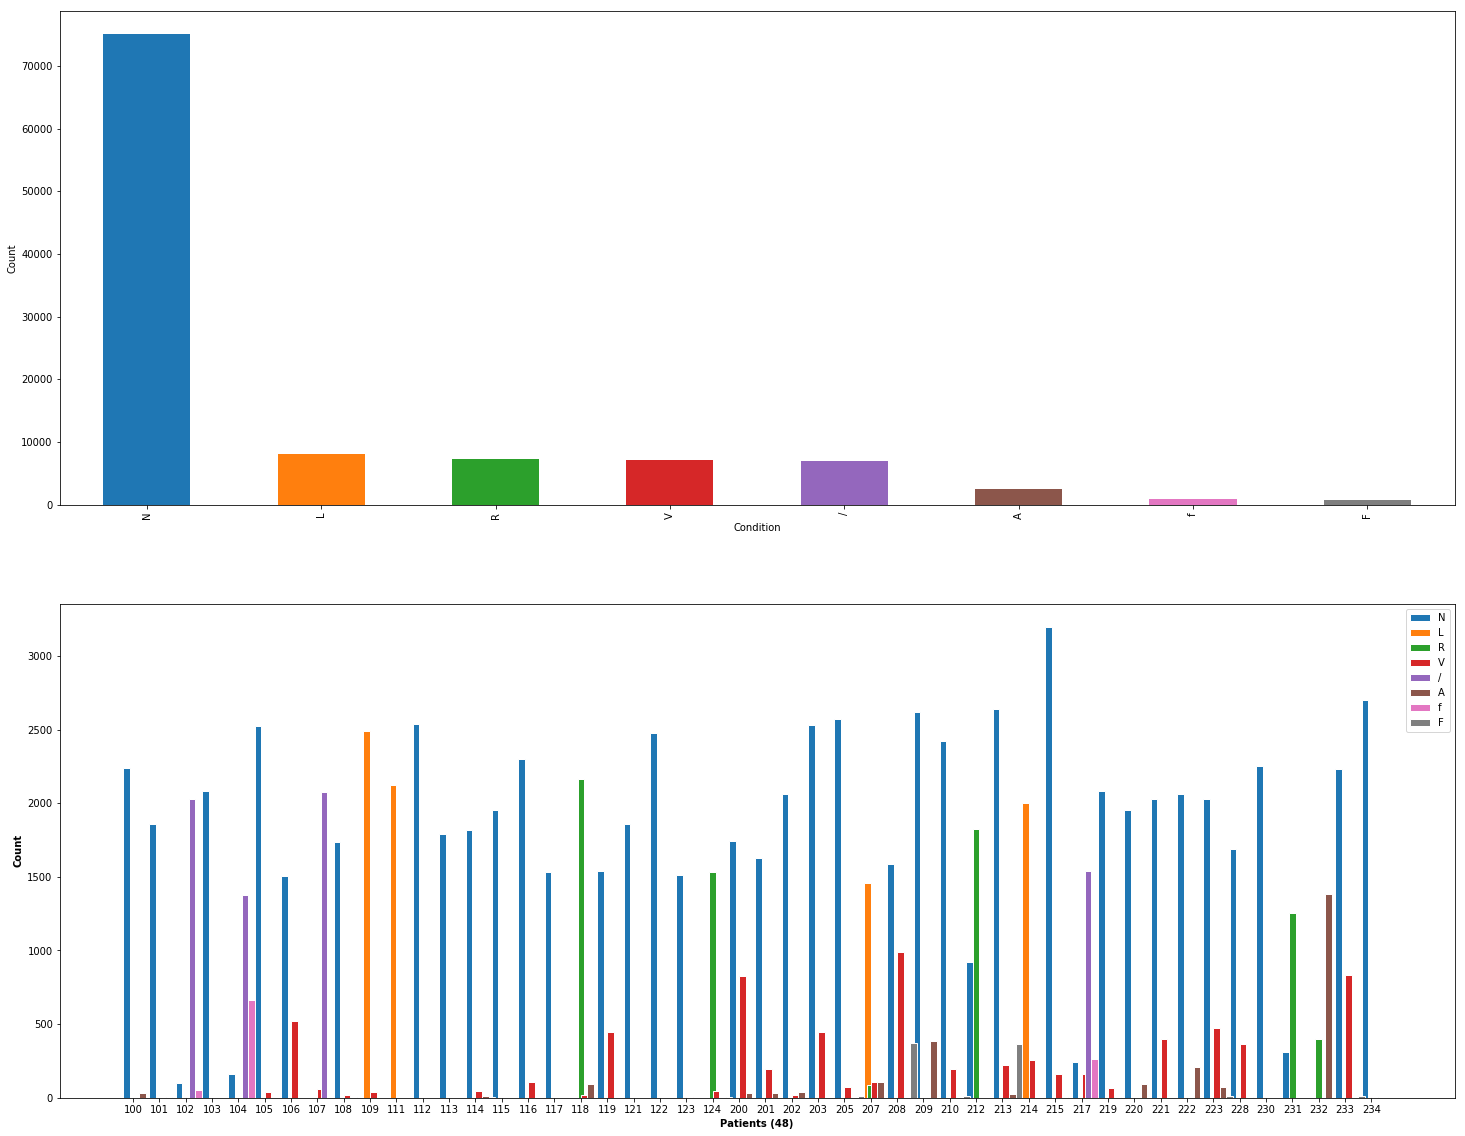

In [0]:
classes= {0:'N',1:'L',2:'R',3:'V',4:'/',5:'A',6:'f',7:'F'}
patient_dic=hb.distribution_bar(patients=hb.all_patients(),classes=classes)

### Lets' Reduce the Number of Classes. Not all patients are represented (Create a connecting Dictionary)

all_classes --> {0:'N',1:'S',2:'V',3:'F',4:'Q'}

In [0]:
classes= {0:'N',1:'S',2:'V',3:'F',4:'Q'}
classes_reducer={'N':['N','L','R','e','j'],
                 'S':['S','A','a','J'],'V':['V','E'],'F':['F'],'Q':['/','Q','f']}
for c, subclass in classes_reducer.items():
    print('For class:',c, '({})'.format(hb.classes_further[c]))
    for i in subclass:
        print("  ({})".format(i), hb.classes_further[i])

For class: N (Normal beat)
  (N) Normal beat
  (L) Left bundle branch block beat
  (R) Right bundle branch block beat
  (e) Atrial escape beat
  (j) Nodal (junctional) escape beat
For class: S (Supraventricular premature beat)
  (S) Supraventricular premature beat
  (A) Atrial premature beat
  (a) Aberrated atrial premature beat
  (J) Nodal (junctional) premature beat
For class: V (Premature ventricular contraction)
  (V) Premature ventricular contraction
  (E) Ventricular escape beat
For class: F (Fusion of ventricular and normal beat)
  (F) Fusion of ventricular and normal beat
For class: Q (Unclassifiable beat)
  (/) Paced beat
  (Q) Unclassifiable beat
  (f) Fusion of paced and normal beat


#### Classes_reducer is an optional argument that can be used to link one class to another
##### Patient Dic is a dictionary that has relevant class proportion information 

Generating_plot(s)...


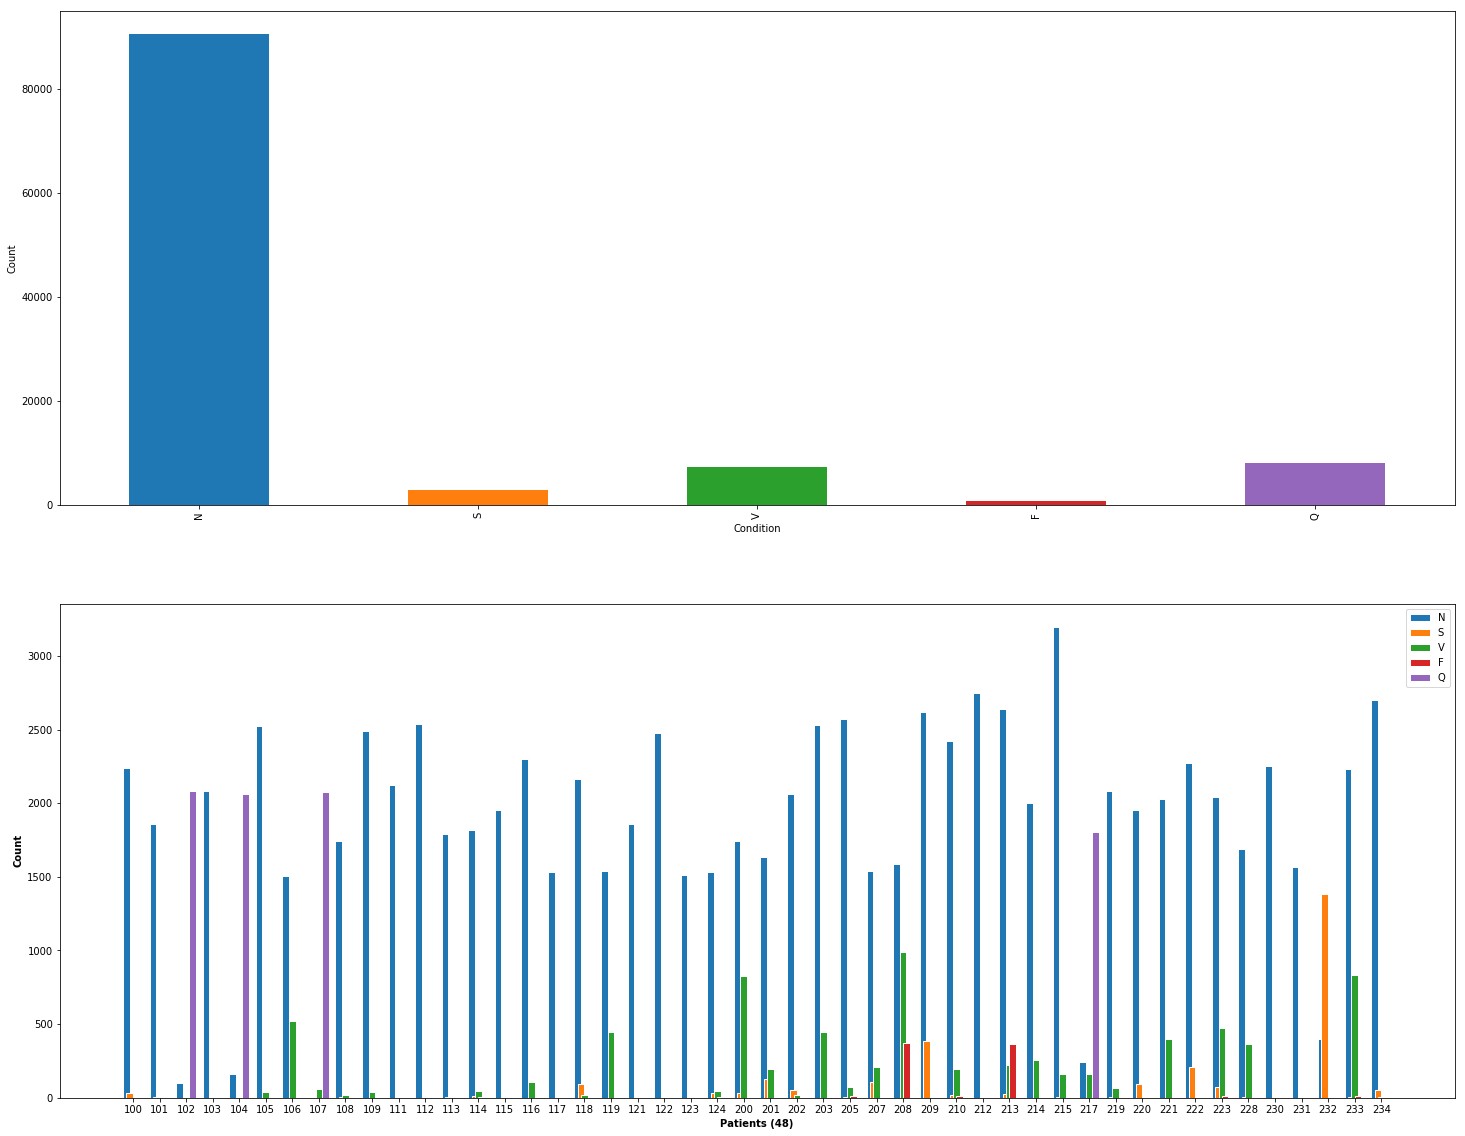

In [0]:
patient_dic=hb.distribution_bar(patients=hb.all_patients(),classes=classes,
                                classes_reducer=classes_reducer)

We notice a better distribution with joined classes. If we remove Normal conditions we can see this a little more clearly. 

Generating_plot(s)...


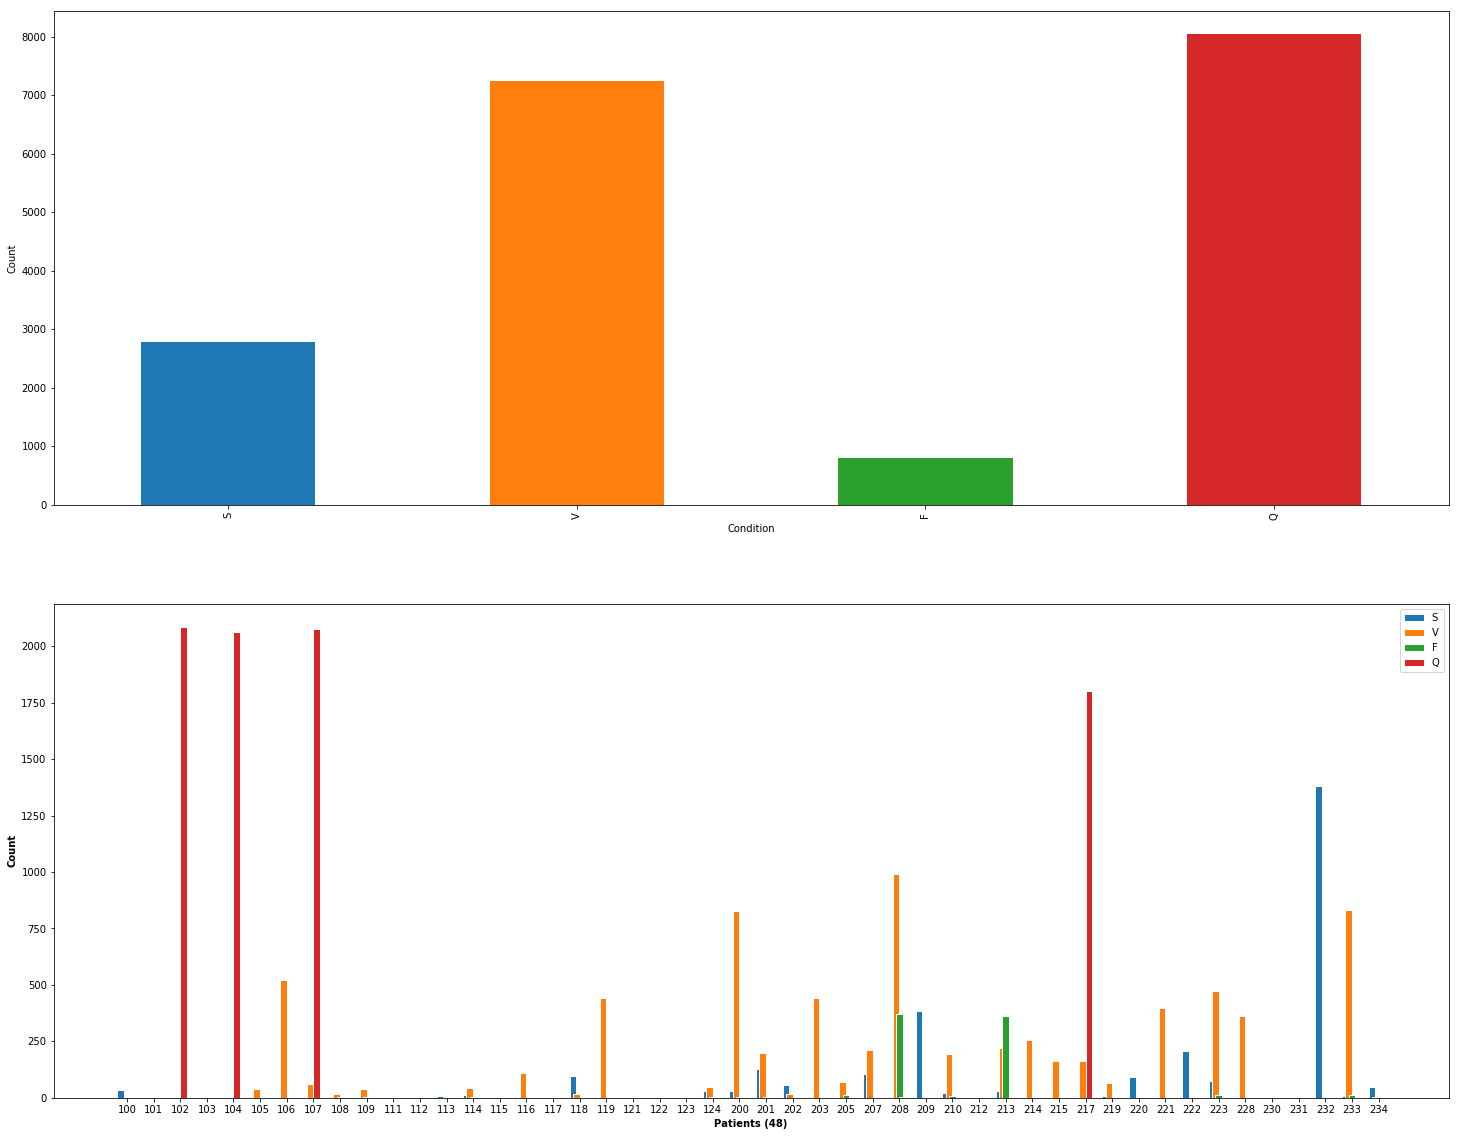

In [0]:
classes_wo_N= {0:'S',1:'V',2:'F',3:'Q'}
patient_dic=hb.distribution_bar(patients=hb.all_patients(),classes=classes_wo_N,
                                classes_reducer=classes_reducer)

### Examing sample heart rate data 
#### Run Cell As Many Times as you like to see how different patients look like (Peaks in Orange)
`hb.all_patients` : list of all patients 100 ~ 234 (48 total)<br/>
`hb.get_patient_data(patient,norm=True, sample_plot=False)`: function to plot<br/>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Assumes that all folder called mit_data is next folder 
    in current directory. 
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Can change this function internally or write your own personalized one. <br/>
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Input: 
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`patient`: Patient Number [Str or Int]
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`norm`: (optional) =True --> Normalize Data 
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`sample_plot`: (optional) Show Patient ECG Signal [True or False]
<br/><br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Output: (If sample_plot == True: only output is a sample figure plot)
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Normalized Signal Data, Ecg Notes 
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`Ecg_Notes`: Labeled Sample Peaks and Heart Conditions 
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`Ecg_Data`: np.array of signal

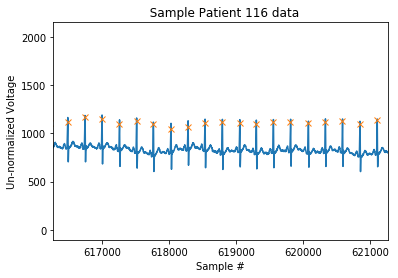

In [0]:
patient=random.choice(hb.all_patients())
hb.get_patient_data(patient,norm=False,sample_plot=True)
plt.ylabel('Un-normalized Voltage')
plt.xlabel('Sample #')
plt.draw()

In [0]:
signal,ecg_notes=hb.get_patient_data(patient=101,norm=False,sample_plot=False)
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

print("Labeled Heart Beats  | Signal Data")
display_side_by_side(ecg_notes.head(),signal.to_frame().head())

Labeled Heart Beats  | Signal Data


sample_num 
 type 
 aux 
 
 
 
 
 0 
 7 
 + 
 (N 
 
 
 1 
 83 
 N 
 NaN 
 
 
 2 
 396 
 N 
 NaN 
 
 
 3 
 711 
 N 
 NaN 
 
 
 4 
 1032 
 N 
 NaN 
 
 
 
 
 
 
 signal 
 
 
 
 
 0 
 955 
 
 
 1 
 955 
 
 
 2 
 955 
 
 
 3 
 955 
 
 
 4 
 955

### Examining the Best Techniques to Normalizing data 
`hb.moving_average`: Numpy based moving average function.
    Input: signal and window size |
    Output: averaged signal
    
  

PATIENT: 231

Norm 1: Creates a mean of 0, and a std of 1
Norm 2: Creates a mean of 0, and y range from [-1 1]
Norm 3: Creates a y range from [0 1]


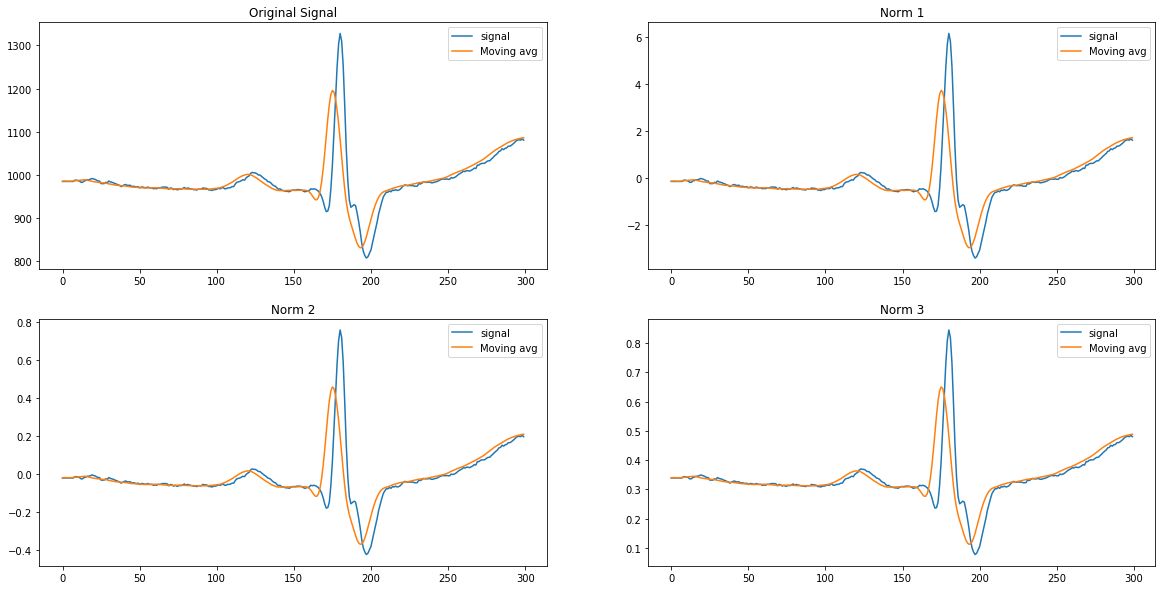

Selected Norm = 3


In [0]:
patient=random.choice(hb.all_patients())
import numpy as np
import matplotlib.pyplot as plt
def compare(patient,length,window=10):
    print("PATIENT: {}\n".format(patient))
    sig,notes= hb.get_patient_data(patient,norm=False)
    m=hb.moving_average(sig,10)
    n = np.random.choice(10*length)
    plt.figure(figsize=(20,10))
    
    plt.subplot(221)
    plt.plot(sig[0:length])
    plt.plot(m[0:length],label='Moving avg')
    plt.legend()
    plt.title('Original Signal')
    
    
    print("Norm 1: Creates a mean of 0, and a std of 1")
    plt.subplot(222)
    plt.plot(normalizer.z_norm_b(sig)[0:length])
    m=hb.moving_average(normalizer.z_norm_b(sig),window)
    plt.plot(m[0:length],label='Moving avg')
    plt.legend()
    plt.title('Norm 1')
    
    print("Norm 2: Creates a mean of 0, and y range from [-1 1]")
    plt.subplot(223)
    plt.plot(normalizer.z_norm2(sig)[0:length])
    m=hb.moving_average(normalizer.z_norm2(sig),window)
    plt.plot(m[0:length],label='Moving avg')
    plt.legend()
    plt.title('Norm 2')

    
    print("Norm 3: Creates a y range from [0 1]")
    plt.subplot(224)
    plt.plot(normalizer.z_norm(sig)[0:length])
    m=hb.moving_average(normalizer.z_norm(sig),window)
    plt.plot(m[0:length],label='Moving avg')
    plt.legend()
    plt.title('Norm 3')
    plt.show()
    
compare(patient=patient,length=300)
print('Selected Norm = 3')

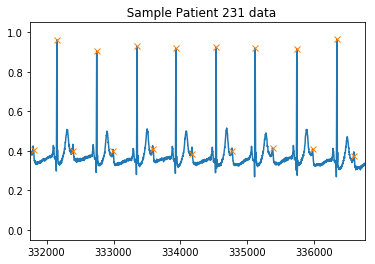

In [0]:
hb.get_patient_data(patient=231,norm=True,sample_plot=True)

### NORM 3 selected and used to normalize data 
`hb.get_patient_data()` with norm flag = True
    
  

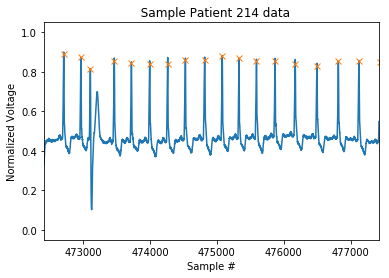

In [0]:
patient=random.choice(hb.all_patients())

hb.get_patient_data(patient,norm=True,sample_plot=True)
plt.ylabel('Normalized Voltage')
plt.xlabel('Sample #')
plt.draw()

### Examing Relevance of Frequency in the Model
#### Run Cell As Many Times as you like to see how different patients look like (Patient Num as Title)

`filt` is a class of various filtration functions 

`filt.low_pass_filter_plot(self,patient,cutoff,fs=360,order=5)` function to show butter worth low pass filter impact<br/>

<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Input: 
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`patient`: Patient Number [Str or Int]
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`cutoff`: cutoff frequency
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`fs`: sample frequency (samples/sec)
<br/><br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Output: (Subplots) 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;FFT (FAST 
FOURIER TRANSFORM)
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Filter Frequency Response
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Example of Filtered signal compared to orignal



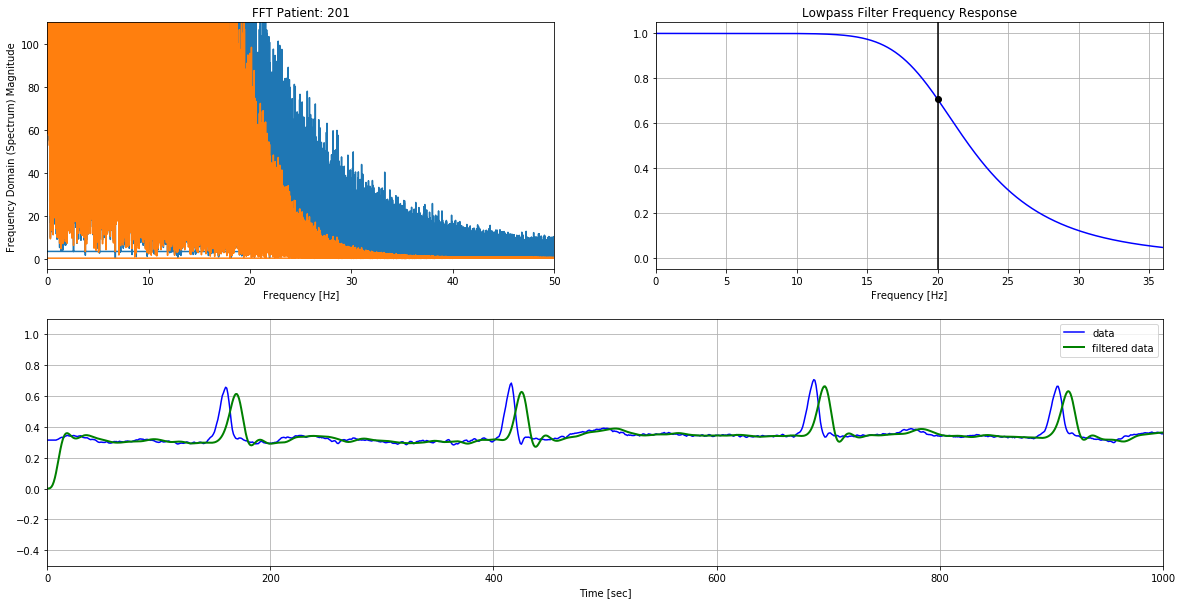

In [0]:
from normalizer import filt  #class of various filteration functions 
patient= random.choice(hb.all_patients())
filt().low_pass_filter_plot(patient=patient,cutoff=20,fs=360)

### Heart Beat Isolation Algorithm 
##### Isolated a long ECG Singal into Peaks: Function can be adapter with `biosppy.christov_segementer`:: https://biosppy.readthedocs.io/en/stable/biosppy.signals.html

`hb.isolate_patient_data(patients,classes,classes_further,min_HR= 40,max_HR= 140,fs=360,verbose=False,plot_figs=True)`: isolation algorithim

<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Input: 
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`patients`: LIST of Patient Numbers [Str or Int]
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`classes`: 
classes to be examined {dic}
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`classes_further`: (hb.classes_further) expansion of previous classes with names {dic}
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`classes_reducer`: (None) optional argument that can be used to link one class to another
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`min_HR`: (optional) minimum HR to consider (longer HR Sample Rate)
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`max_HR`: (optional) max HR to consider (longer HR Sample Rate)
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`fs`: (optional) sampling frequency --> 360 for this database
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`verbose`: (optional) prints out some information per patient if true [boolean]<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`plot_figs`: 
plot_figs:: (optional) prints out HR and Heat Beat distributions 

<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Output: 
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;X, y, isolated Beats  
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`X`: np arrays of each heart beat signal (normed + zero_padded)
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`y`: np arrays of [patient, HR, and HeartBeat Class]
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`Isolated Beat`: list of lists (unpadded) of signal and associated labels

Examining 48 patients...
Percent: [>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 100.00% Done...

Padding...


Average HR Sample Len: 284.39 samples (0.79s per beat)
Average HR: 80.61 bpm
Plotting...



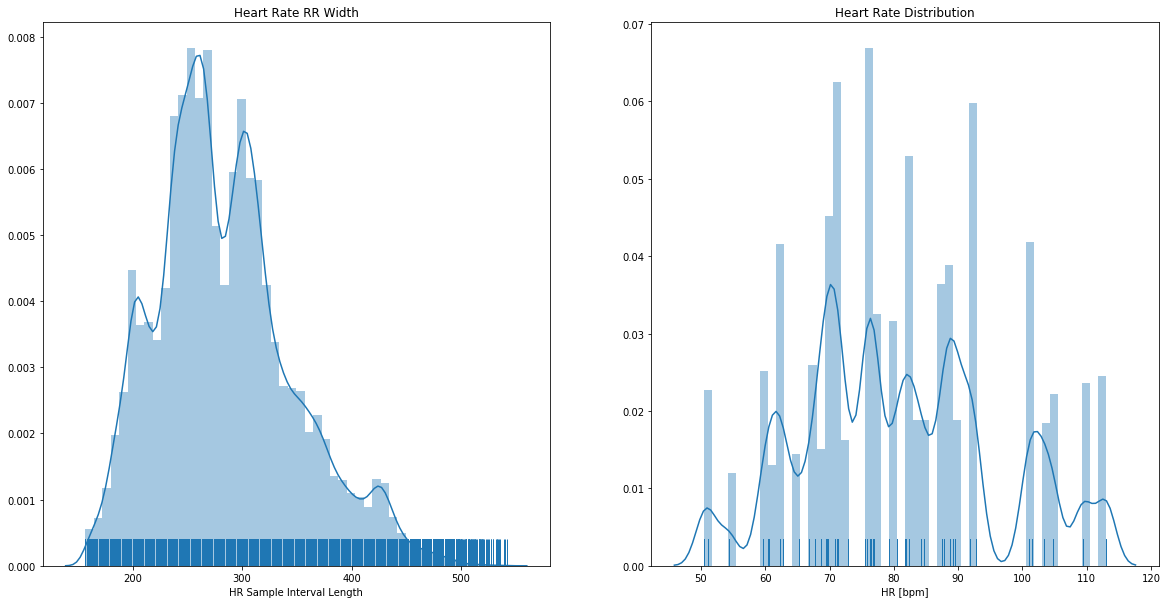

Data Loaded | Shape:(107726, 542)

    89696 cases of Normal beat

    2388 cases of Supraventricular premature beat

    6827 cases of Premature ventricular contraction

    8028 cases of Unclassifiable beat

    787 cases of Fusion of ventricular and normal beat

4.64min Runtime


In [0]:
#isolation algorithim heart beat data 
X,y,isolated_beat= hb.isolate_patient_data(patients=hb.all_patients(),classes=classes,
                    classes_further=hb.classes_further, classes_reducer=classes_reducer, 
                     min_HR= 40,max_HR= 140,fs=360,verbose=False,plot_figs=True)

In [0]:
print("X shape:", X.shape)
print("y shape:", y.shape)
print("sample y vals:: [patient#, HR, Condition Class]:",y[0])

X shape: (107726, 539)
y shape: (107726, 3)
sample y vals:: [patient#, HR, Condition Class]: ['100' '75.536676138855' 'N']


### Looking into Isolated Heart Beats 

Grouping these classes is actually proves to be realistic


`hb.show_sample_plots(X,y,classes,classes_further,num_sigs=5,fs=360,plot_xlim=1)`: isolation algorithim

<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Input: 
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`X`: np arrays of each heart beat signal (normed + zero_padded)
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`y`: np arrays of [patient, HR, and HeartBeat Class]
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`Isolated Beat`: list of lists (unpadded) of signal and associated labelsLIST of Patient Numbers [Str or Int]
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`classes`: 
classes to be examined {dic}
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`classes_further`: (hb.classes_further) expansion of previous classes with names {dic}
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`num_sigs`: number of signals (per class) to over lay
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`fs`: (optional) sampling frequency --> 360 for this database
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`plot_xlim`: number of seconds to show (1s) on x axis 

<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Output: 
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Heart Beat Subplots per Class  


MAX HB TIME: 1.4972222222222222


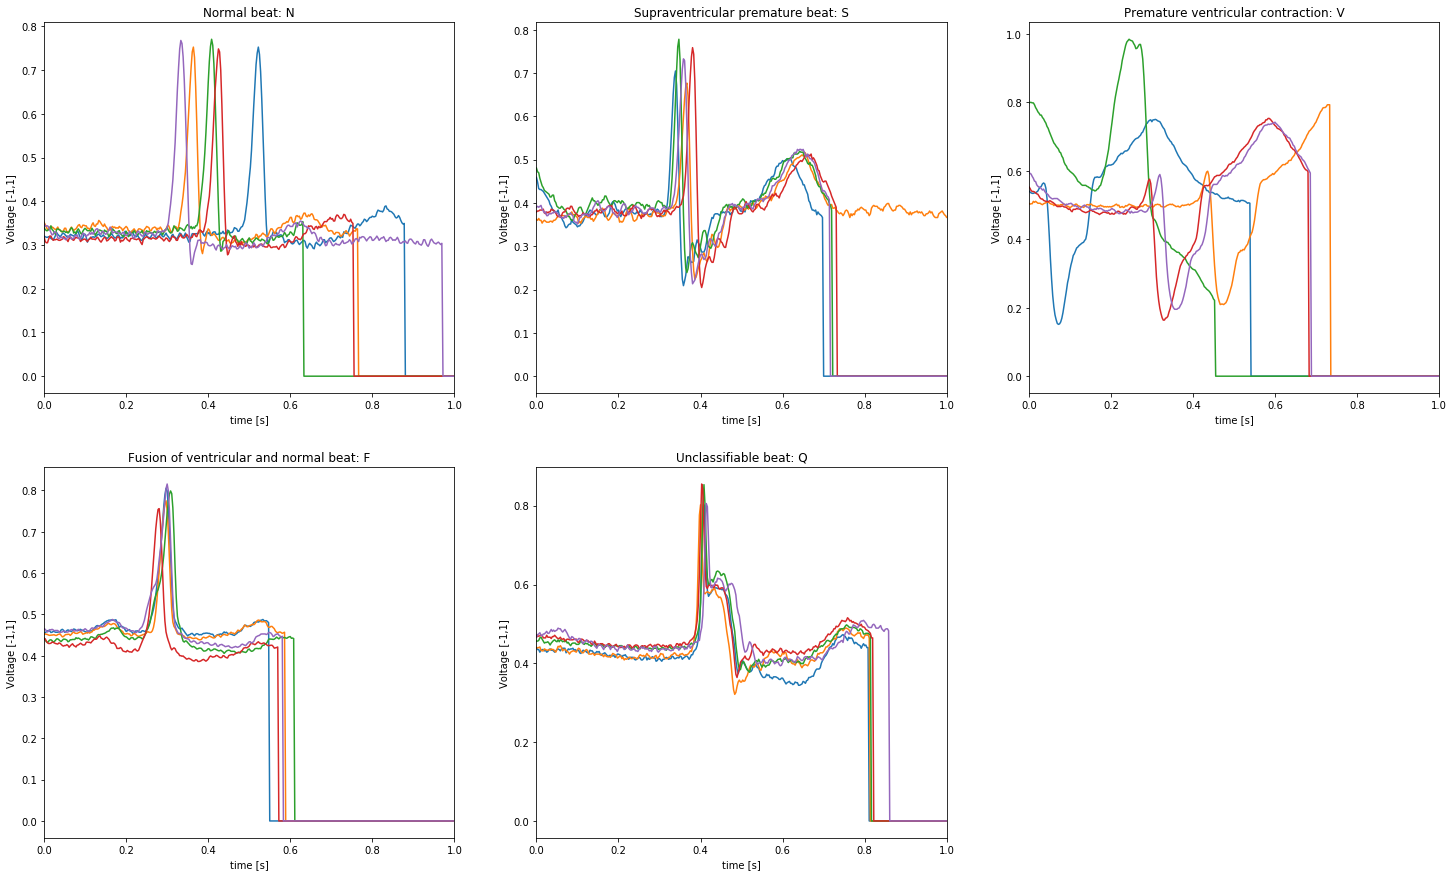

In [0]:
hb.show_sample_plots(X=X,y=y,classes=classes,classes_further=hb.classes_further,plot_xlim=1,dims=[2,3])

### Resampling 360 Hz (How many data points do we need with out losing too much information per signal?)

##### (360Hz/2 ~ 180-190 Hz) 


`hb.resample_vals(X,samp_len)`: Resampling Algorithim 

<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Input: 
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`X`: np arrays of each heart beat signal (normed + zero_padded)
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;`sample_len`: New Length to Resample. reample_len must be < len(X[n]) to down sample 

<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Output: 
<br/>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; X resampled  


In [0]:
# Cut Roughly in Half 
print('Resampling...\n')
X_resamp=hb.resample_vals(X,samp_len=187)
print("X_resamp shape:", X_resamp.shape)
print("y shape:", y.shape)

Resampling...

X_resamp shape: (107726, 187)
y shape: (107726, 3)


### How Resampling (looking at about 1/2 second) looks like. 
##### Singals are all preseved with out the model getting to occupied with to much data

MAX HB TIME: 0.5194444444444445


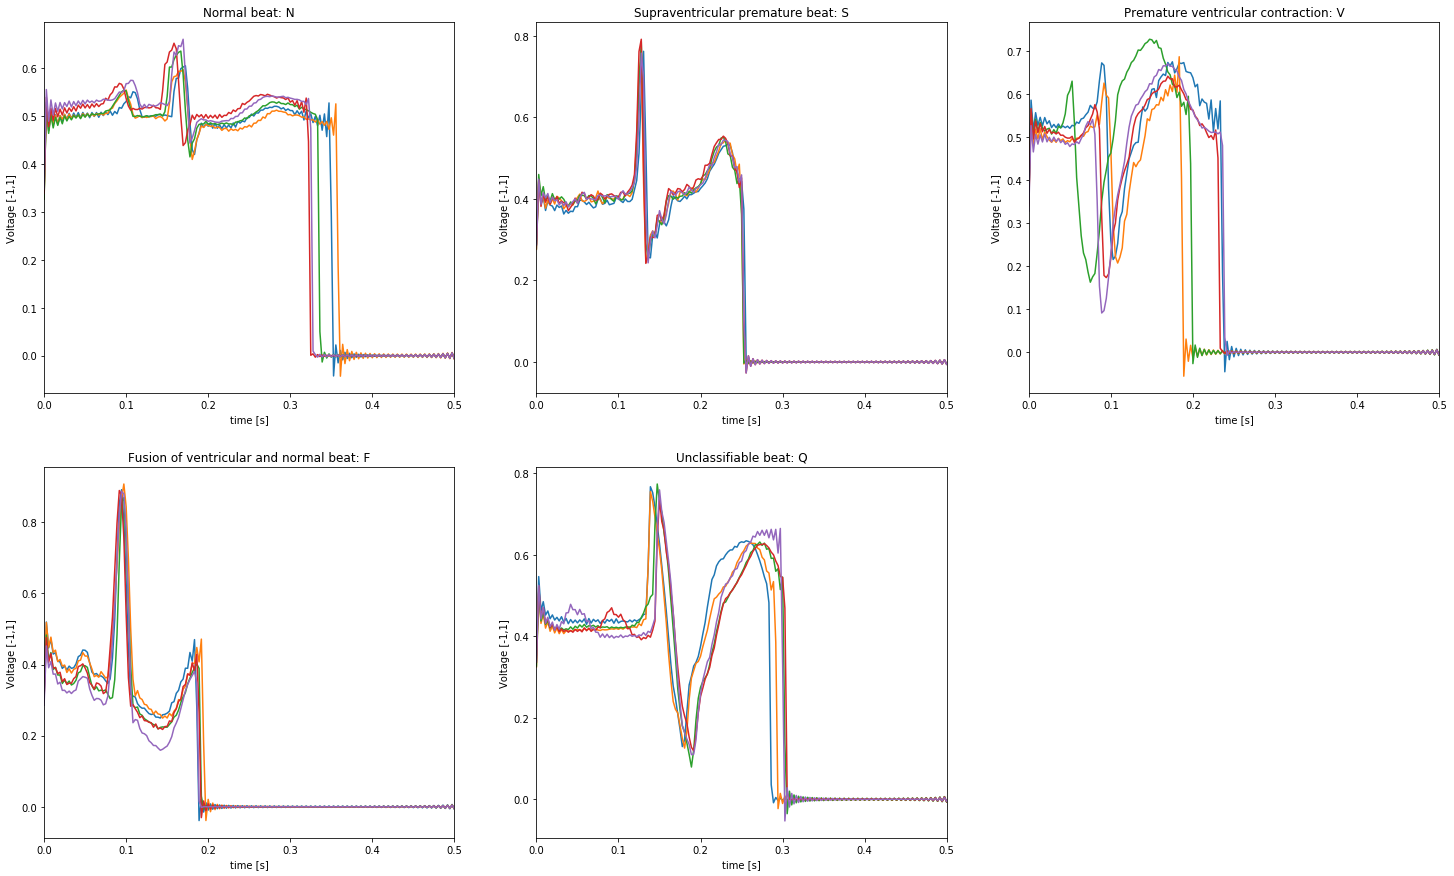

In [0]:
hb.show_sample_plots(X=X_resamp,y=y,classes=classes,classes_further=hb.classes_further,
                     plot_xlim=.5,dims=[2,3])

### Lets Save X,y and use Torch to see how the model performs on a deep learning frame work using COLAB GPU

In [0]:
pd.DataFrame(X_resamp).to_csv("/Users/eddymina/Code/python/notebooks/DS4440/DS_Final/X_resamped.csv")

In [0]:
pd.DataFrame(y).to_csv("/Users/eddymina/Code/python/notebooks/DS4440/DS_Final/y.csv")

___
### CONTINUE to Link Below. Model is Run on Google CoLAB GPU 

https://colab.research.google.com/drive/1U0eBECjDVoA6HChHBKlEGcVOeaKhjrMb

---

# Deep Learning 

#### 1. Uploading Data from (CPU) to CoLab 
#### 2. Dividing and Preparing Data For Training 
#### 3. Design Model In Pytorch (CUDA)
#### 4. Develop Training and Evaluation Metrics 
#### 5. Results
---

### Uploading Data from (CPU) to CoLab

In [0]:
####Get (Processed Data) into Google Drive 
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd 
import numpy as np 
from random import choices
from collections import Counter 


X_resamp= pd.read_csv('/content/gdrive/My Drive/processed_ecg_data/X_resamped.csv')
y= pd.read_csv('/content/gdrive/My Drive/processed_ecg_data/y_i.csv')

X_resamp=X_resamp.drop(X_resamp.columns[0],axis=1).values
y=y.drop(y.columns[0],axis=1).values

classes={0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}
print('X (resampled):',X_resamp.shape,'y:',y.shape,'Classes:',classes)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive
X (resampled): (107726, 187) y: (107726, 3) Classes: {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}


In [0]:
def get_key(val,my_dict): 
    """
    Simple Function to Get Key 
    in Dictionary from val. 
    
    Input: Key, Dictionary 
    Output: Val
    
    """
    for key, value in my_dict.items(): 
         if val == value: 
            return key 
    return "key doesn't exist"

def one_hot(c,classes=classes):
    """
    Simple one hot encoding for the 
    types of arrthymia conditions. 
    
    class --> encode class
    'N' --> [1, 0, 0, 0, 0, 0, 0, 0]
    
    c:: current class of the object
    classes:: classes dictionary 
        
    """
    enc=np.zeros(len(classes),dtype=int).tolist()
    enc[get_key(c,classes)]= 1
    return enc
  
all_patients=['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
              '122', '123', '124', '200', '201', '202', '203', '205', '207', '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', 
              '222', '223', '228', '230', '231', '232', '233', '234']

### Dividing and Prepping Data for DL

In [0]:
from sklearn.utils import shuffle
def get_train_test(X,y,train_size,classes=classes,patients=all_patients):
  """
  Get train and test function for spliting ensuring testing has all classes
  preseting for testing/eval to see how well all classes are performing. 
  """

  sub_c={}
    
 
  for c in classes:
      C = np.argwhere(y[:,2] == list(classes.values())[c]).flatten()

      sub_c[c]=np.random.choice(C,int((C.shape[0]- C.shape[0]*train_size)))

  X_test = np.vstack([X[sub_c[0]], X[sub_c[1]], X[sub_c[2]], X[sub_c[3]], X[sub_c[4]]])
  y_test = np.vstack([y[sub_c[0]], y[sub_c[1]], y[sub_c[2]], y[sub_c[3]], y[sub_c[4]]])

  deletions=[]
  for i in range(len(sub_c)):
    deletions.extend(sub_c[i].tolist())
  
  X_train = np.delete(X, deletions, axis=0)
  y_train = np.delete(y, deletions, axis=0)

  X_train, y_train = shuffle(X_train, y_train, random_state=0)
  X_test, y_test = shuffle(X_test, y_test, random_state=0)
  y_train= np.array([get_key(y_i,classes) for y_i in y_train[:,2]])
  y_test= np.array([get_key(y_i,classes) for y_i in y_test[:,2]])
  return X_train,y_train,X_test,y_test

  

X_train,y_train,X_test,y_test=get_train_test(X=X_resamp,y=y,train_size=.80)
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
  

X_train: (88246, 187)
y_train: (88246,)
X_test: (21543, 187)
y_test: (21543,)


#### Get Train, Validation, and Test Loader 

In [0]:
import warnings
from torch.utils.data.sampler import WeightedRandomSampler
import torch
from torch import optim 
import random
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler
import random
from torch.autograd import Variable

def imbalanced_loader(X_train,y_train,X_test,y_test,valid_size=.05,batch_size=512): # Split train into train + validation 
    """
    Get trainloader, validloader, and testloader for model training. This 
    creates equal training batches but naturally balanced validation and testing 
    sets. Note the testing set was previously augmented to get better per class metrics 
    
    Outputs: dataloader + testloader, where dataloader =  {"train": trainloader, "val": validloader}

    """
    warnings.filterwarnings("ignore") #torch bug
    print ('Getting Data... {}% Validation Set\n'.format(int(np.around(valid_size*100))))
    
    num_train = len(X_train)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    print("Batch Size:",batch_size)

    print('\nTrain Len=',len(train_idx),', Validation Len=',len(valid_idx), 'Test Len=',len(y_test))
                                                                                        
  
    class_sample_count = np.array([len(np.where(y_train[[train_idx]]==t)[0]) for t in np.unique(y_train[[train_idx]])])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in y_train[[train_idx]]])
    samples_weight = torch.from_numpy(samples_weight)
    train_sampler = WeightedRandomSampler(torch.tensor(samples_weight,dtype=torch.double), len(samples_weight))
    trainDataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train[[train_idx]]), torch.LongTensor(y_train[[train_idx]].astype(int)))
    train_sampler= torch.utils.data.BatchSampler(sampler=train_sampler, batch_size=batch_size, drop_last=True)
    trainloader = torch.utils.data.DataLoader(dataset = trainDataset, batch_size=batch_size, num_workers=1, sampler= train_sampler)
  
    
    valDataset = torch.utils.data.TensorDataset(torch.FloatTensor(X_train[[valid_idx]]), torch.LongTensor(y_train[[valid_idx]].astype(int)))
    sampler = torch.utils.data.RandomSampler(valDataset)
    sampler= torch.utils.data.BatchSampler(sampler, batch_size, drop_last=True)
    validloader = torch.utils.data.DataLoader(dataset = valDataset, batch_size=batch_size, num_workers=1,sampler=sampler)


    testset=[]
    for i,x in enumerate(X_test):
        testset.append((torch.from_numpy(x),torch.tensor([y_test[i]])))
    
    #testloader = torch.utils.data.DataLoader(dataset = testDataset, batch_size=batch_size, shuffle=False, num_workers=1) 
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                           shuffle=False, num_workers=1)

    print("")
    dataloader = {"train": trainloader, "val": validloader}
    print('Train Size Batched=',int(len(dataloader['train'].dataset)/batch_size),', Validation Size Batched=',int(len(dataloader['val'].dataset)/batch_size),', Test Size Batched=',len(testloader))
    
    
    warnings.resetwarnings()
    return dataloader,testloader
  
batch_size=512
dataloader,testloader = imbalanced_loader(X_train=X_train,y_train=y_train,X_test=X_test,y_test=y_test, valid_size=.05,batch_size=batch_size)

Getting Data... 5% Validation Set

Batch Size: 512

Train Len= 83834 , Validation Len= 4412 Test Len= 21543

Train Size Batched= 163 , Validation Size Batched= 8 , Test Size Batched= 43


#### Lets see how classes are balanced for training 
(Testing and Validation sets have natural balance)

In [0]:
for hb,labels in dataloader['train']:
    for hb_index,label in enumerate(labels):
        print(hb_index,hb[hb_index].size(),label.cpu().numpy().shape,Counter(label.cpu().numpy().flatten()))

0 torch.Size([512, 187]) (512,) Counter({3: 108, 0: 107, 1: 107, 2: 98, 4: 92})
1 torch.Size([512, 187]) (512,) Counter({1: 113, 0: 108, 3: 105, 2: 102, 4: 84})
2 torch.Size([512, 187]) (512,) Counter({1: 111, 2: 104, 4: 100, 0: 99, 3: 98})
3 torch.Size([512, 187]) (512,) Counter({0: 121, 3: 108, 1: 102, 2: 98, 4: 83})
4 torch.Size([512, 187]) (512,) Counter({4: 108, 3: 107, 0: 106, 2: 96, 1: 95})
5 torch.Size([512, 187]) (512,) Counter({4: 114, 1: 109, 3: 105, 0: 102, 2: 82})
6 torch.Size([512, 187]) (512,) Counter({0: 122, 4: 115, 1: 95, 3: 91, 2: 89})
7 torch.Size([512, 187]) (512,) Counter({0: 113, 4: 113, 1: 108, 3: 91, 2: 87})
8 torch.Size([512, 187]) (512,) Counter({0: 119, 1: 104, 3: 101, 4: 96, 2: 92})
9 torch.Size([512, 187]) (512,) Counter({3: 117, 0: 105, 2: 99, 1: 96, 4: 95})
10 torch.Size([512, 187]) (512,) Counter({3: 129, 1: 101, 4: 101, 0: 91, 2: 90})
11 torch.Size([512, 187]) (512,) Counter({1: 108, 0: 108, 3: 108, 2: 95, 4: 93})
12 torch.Size([512, 187]) (512,) Count

### Model Architecture 

In [0]:
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

print("""\nA 1D CNN is very effective when you expect to derive interesting features from shorter 
(fixed-length) segments of the overall data set and where the location of the feature 
within the segment is not of high relevance.\n""")

class Anomaly_Classifier(nn.Module):
    def __init__(self, input_size,num_classes):
        super(Anomaly_Classifier, self).__init__()
    
        self.conv= nn.Conv1d(in_channels=input_size, out_channels=32, kernel_size=5,stride=1)
        
        self.conv_pad = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5,stride=1,padding=2)
        self.drop_50 = nn.Dropout(p=0.5)

        self.maxpool = nn.MaxPool1d(kernel_size=5,stride=2) 

        self.dense1 = nn.Linear(32 * 8, 32) 
        self.dense2 = nn.Linear(32, 32) 
        
        self.dense_final = nn.Linear(32, num_classes)
        self.softmax= nn.LogSoftmax(dim=1)

  
    def forward(self, x):
        residual= self.conv(x)
      
        #block1 
        x = F.relu(self.conv_pad(residual))
        x = self.conv_pad(x)
        x+= residual 
        x = F.relu(x)
        residual = self.maxpool(x) #[512 32 90]
       
        #block2
        x=F.relu(self.conv_pad(residual))
        x=self.conv_pad(x)
        x+=residual
        x= F.relu(x)
        residual = self.maxpool(x) #[512 32 43]
        
        
        #block3
        x=F.relu(self.conv_pad(residual))
        x=self.conv_pad(x)
        x+=residual
        x= F.relu(x)
        residual = self.maxpool(x) #[512 32 20]
        
        
        #block4
        x=F.relu(self.conv_pad(residual))
        x=self.conv_pad(x)
        x+=residual
        x= F.relu(x)
        x= self.maxpool(x) #[512 32 8]
        

        #MLP
        x = x.view(-1, 32 * 8) #Reshape (current_dim, 32*2)
        x = F.relu(self.dense1(x))
        #x = self.drop_60(x)
        x= self.dense2(x)
        x = self.softmax(self.dense_final(x))
        return x
      
print('Model Architecture Init\n')

print("OPTIMIZER = optim.Adam(anom_classifier.parameters(),lr = 0.001) \n ")



cuda:0

A 1D CNN is very effective when you expect to derive interesting features from shorter 
(fixed-length) segments of the overall data set and where the location of the feature 
within the segment is not of high relevance.

Model Architecture Init

OPTIMIZER = optim.Adam(anom_classifier.parameters(),lr = 0.001) 
 


### Training and Evaluation Functions

In [0]:

import matplotlib.pyplot as plt 
import torch.optim as optim
import time 
import sklearn 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools


def reset_weights(model):
  """
  model.apply(reset_weights) will reset all the model parameters.
  This way the model is not overwhelmed 
  
  """
  if isinstance(model, nn.Conv1d) or isinstance(model, nn.Linear):
      model.reset_parameters()
      
def calc_accuracy(output,Y):
  
    # get acc_scores during training 
    max_vals, max_indices = torch.max(output,1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
  
def train_model(data_loader, model, criterion,optimizer, n_epochs=100,print_every=10,verbose=True,plot_results=True,validation=True):
  
  """
  Model Training Function.
  Input:
    
    Dataloader: {'train':trainloader,'val':validloader} --> If no validation is used set Validation = False & dataloader= {'train':trainloader}
    model: model.cuda() if gpu will be used, else cpu
    print_every: print every n epochs 
    verbose: print out results per epoch 
    plot_results: plot the train and valid loss 
    validation: is validation set in dataloader
  
  Output:
  
    trained classifier 
  
  """

  losses=[]
  start= time.time()
  print('Training for {} epochs...\n'.format(n_epochs))
  for epoch in range(n_epochs):
      if verbose == True and epoch % print_every== 0:
        print('\n\nEpoch {}/{}:'.format(epoch+1, n_epochs))
        
      if validation == True: 
        evaluation=['train', 'val']
      else:
        
        evaluation=['train']
        
      # Each epoch has a training and validation phase
      for phase in evaluation:
          if phase == 'train': 
              model.train(True)  # Set model to training mode
          else:
              model.train(False)  # Set model to evaluate mode

          running_loss = 0.0

          # Iterate over data.
          for hb,labels in data_loader[phase]:
            for hb_index,label in enumerate(labels):
#                 print(hb[hb_index].size(),label.cpu().numpy().shape,Counter(label.cpu().numpy().flatten()))
    
 
                HB, label = hb[hb_index].unsqueeze(1).cuda(), label.cuda()


                # forward + backward + optimize
                outputs = model(HB)

                acc= calc_accuracy(outputs,label)

                loss = criterion(outputs, label)#loss function 

                # zero the parameter (weight) gradients
                optimizer.zero_grad()

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    # update the weights
                    optimizer.step()

                # print loss statistics
                running_loss += loss.item()

            losses.append(running_loss) 

          if verbose == True and epoch % print_every== 0: 
            print('{} loss: {:.4f} | acc: {:.4f}|'.format(phase, running_loss,acc), end=' ')
  if verbose == True:        
    print('\nFinished Training  | Time:{}'.format(time.time()-start))
  if plot_results == True:
    plt.figure(figsize=(10,10))
    plt.plot(losses[0::2],label='train_loss')
    if validation == True:
      plt.plot(losses[1::2],label='validation_loss')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.draw()
  
  return model 



def evaluate(testloader, trained_model,verbose= True):
  """
  Evaluation Metric Platfrom. Feed in the trained model 
  and test loader data. 
  
  Returns classification metric along with 
  predictions,truths
  
  """
  
  truth=[]
  preds=[]
  for hb,label in testloader:
      HB, label = hb.float().unsqueeze(1).cuda(), label.cuda()
      outputs = trained_model(HB)
      _, predicted = torch.max(outputs, 1)
      preds.append(predicted.cpu().numpy().tolist())
      truth.append(label.cpu().numpy().tolist())
  
  preds_flat = [item for sublist in preds for item in sublist]
  truth_flat = [item for sublist in truth for item in sublist] 
 

  if verbose == True:
    print('\nEvaluating....')
    print("TEST ACC:",accuracy_score(truth_flat,preds_flat))
    print(classification_report(truth_flat,preds_flat))
  
  return preds_flat,truth_flat



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    
    
def get_kernel_size(n_h,k_h,n_w,k_w,p_h=0,s_h=1,p_w=0,s_w=1):
    """
    Kernel Measuring Function 
    """
    return [int((n_h-k_h+p_h+s_h)/s_h),int((n_w-k_w+p_w+s_w)/s_w)]    
    
    
def variation(n_epochs,num_iters=5):
  p=[]
  t=[]
  accuracy_scores=[]
  for i in range(num_iters):
    print('\nModel {}/{}...\n'.format(i+1,num_iters))
    Anomaly_Classifier(input_size=1,num_classes= 5).cuda().apply(reset_weights)
    print('Weights Reset')
    anom_classifier= Anomaly_Classifier(input_size=1,num_classes= 8).cuda()
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(anom_classifier.parameters(),lr = 0.001) 
    trained_classifier= train_model(data_loader=dataloader, model=anom_classifier,
                                    criterion = criterion,optimizer = optimizer ,
                                    n_epochs=n_epochs,print_every=1,verbose=False,plot_results=False, 
                                    validation=True)
    
    preds,truth = evaluate(testloader=testloader, trained_model = trained_classifier,verbose=False)
    t.append(truth)
    p.append(preds)
    print(accuracy_score(truth,preds))
    accuracy_scores.append(accuracy_score(truth,preds))
  return p,t,accuracy_scores
print('Functions Ready')
    

Functions Ready


## Training 

Weights Reset
Training for 100 epochs...



Epoch 1/100:
train loss: 151.7375 | acc: 0.8125| val loss: 6.5242 | acc: 0.6504| 

Epoch 11/100:
train loss: 22.2183 | acc: 0.9707| val loss: 1.4895 | acc: 0.9453| 

Epoch 21/100:
train loss: 13.6798 | acc: 0.9297| val loss: 1.1093 | acc: 0.9609| 

Epoch 31/100:
train loss: 8.8655 | acc: 0.9844| val loss: 0.7679 | acc: 0.9688| 

Epoch 41/100:
train loss: 7.5931 | acc: 0.9883| val loss: 0.8825 | acc: 0.9746| 

Epoch 51/100:
train loss: 6.1625 | acc: 0.9922| val loss: 0.8970 | acc: 0.9727| 

Epoch 61/100:
train loss: 5.0410 | acc: 0.9922| val loss: 0.9090 | acc: 0.9727| 

Epoch 71/100:
train loss: 3.7847 | acc: 0.9961| val loss: 0.6885 | acc: 0.9805| 

Epoch 81/100:
train loss: 4.2471 | acc: 0.9922| val loss: 0.7987 | acc: 0.9863| 

Epoch 91/100:
train loss: 3.6588 | acc: 0.9941| val loss: 0.5975 | acc: 0.9863| 
Finished Training  | Time:519.1606805324554

Evaluating....
TEST ACC: 0.9831499791115443
              precision    recall  f1-score  

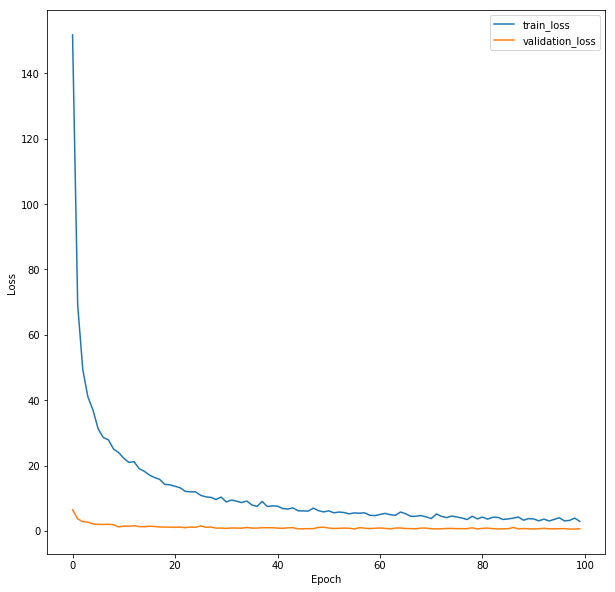

In [0]:
Anomaly_Classifier(input_size=1,num_classes= 5).cuda().apply(reset_weights)
print('Weights Reset')
anom_classifier= Anomaly_Classifier(input_size=1,num_classes= 5).cuda()
criterion = nn.NLLLoss()
optimizer = optim.Adam(anom_classifier.parameters(),lr = 0.001) 
trained_classifier2 = train_model(data_loader=dataloader, model=anom_classifier, criterion = criterion,optimizer = optimizer ,
                                            n_epochs=100,print_every=10,verbose=True,plot_results=True, validation=True)
preds,truth = evaluate(testloader=testloader, trained_model = trained_classifier2,verbose=True)

Normalized confusion matrix


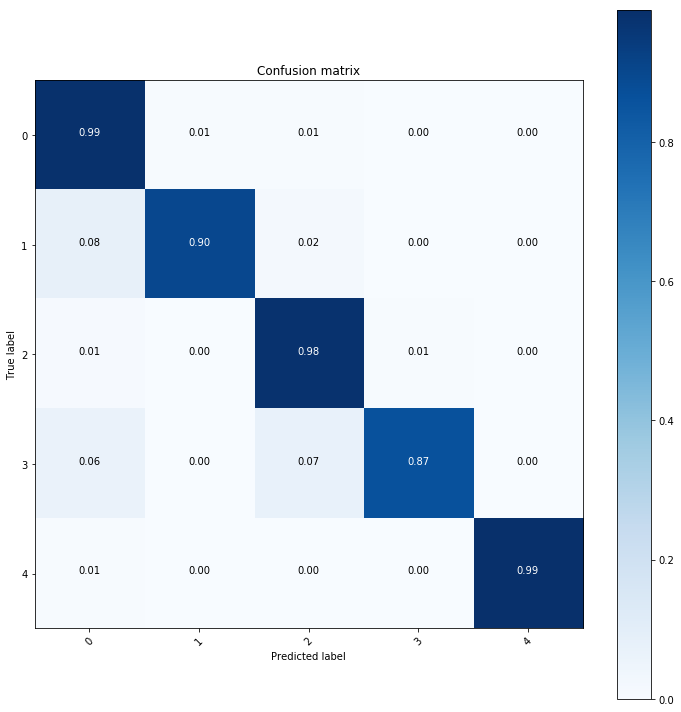

In [0]:
cm = confusion_matrix(y_true=truth, y_pred=preds)
plot_confusion_matrix(cm=cm,normalize=True,classes=classes)


Model 1/5...

Weights Reset
Training for 100 epochs...

0.9695492735459313

Model 2/5...

Weights Reset
Training for 100 epochs...

0.9736341270946479

Model 3/5...

Weights Reset
Training for 100 epochs...

0.9730306828204057

Model 4/5...

Weights Reset
Training for 100 epochs...

0.9829178851599127

Model 5/5...

Weights Reset
Training for 100 epochs...

0.9748410156431323
[0.9695492735459313, 0.9736341270946479, 0.9730306828204057, 0.9829178851599127, 0.9748410156431323]


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


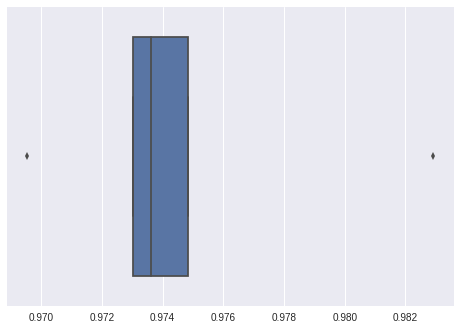

In [0]:
s=time.time()
acc=variation(n_epochs=100,num_iters=5)
time.time()-s
import seaborn as sns 
print(acc)
sns.boxplot(acc)
plt.show()

[0.9695492735459313, 0.9736341270946479, 0.9730306828204057, 0.9829178851599127, 0.9748410156431323]


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


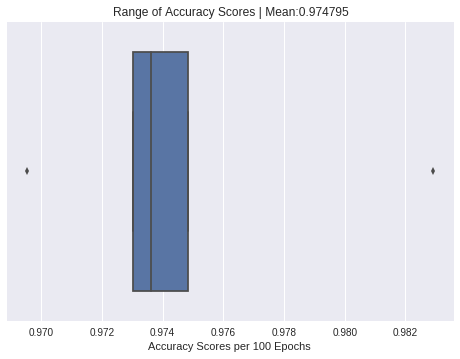

In [0]:
import seaborn as sns 
print(acc)
sns.boxplot(acc)
plt.title('Range of Accuracy Scores | Mean:{:8f}'.format(np.mean(acc)))
plt.xlabel('Accuracy Scores per 100 Epochs ')
plt.show()